# Advanced Lane Lines 
### The objective of this project is to identify the lane boundaries in a video from a front-facing camera on a car.  

In this notebook, we are going to build a computer vision model for identifying lane lines in road images.
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
* Apply a distortion correction to raw images
* Apply color transforms to generate a binary thresholded image
* Apply a perspective transform to warp binary image ("birds-eye view")
* Detect lane pixels and find the lane boundaries
* Determine left/right radius of curvature and vehicle position with respect to center
* Warp the detected lane boundaries back onto the original image
* Output visual display of the lane boundaries, left/right radius of curvature, vehicle position, and tracking success/error

In [8]:
import cv2
import glob
import os
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Camera Calibration
Calibrate the camera using several chessboard images with 6x9 or 5x9 corners

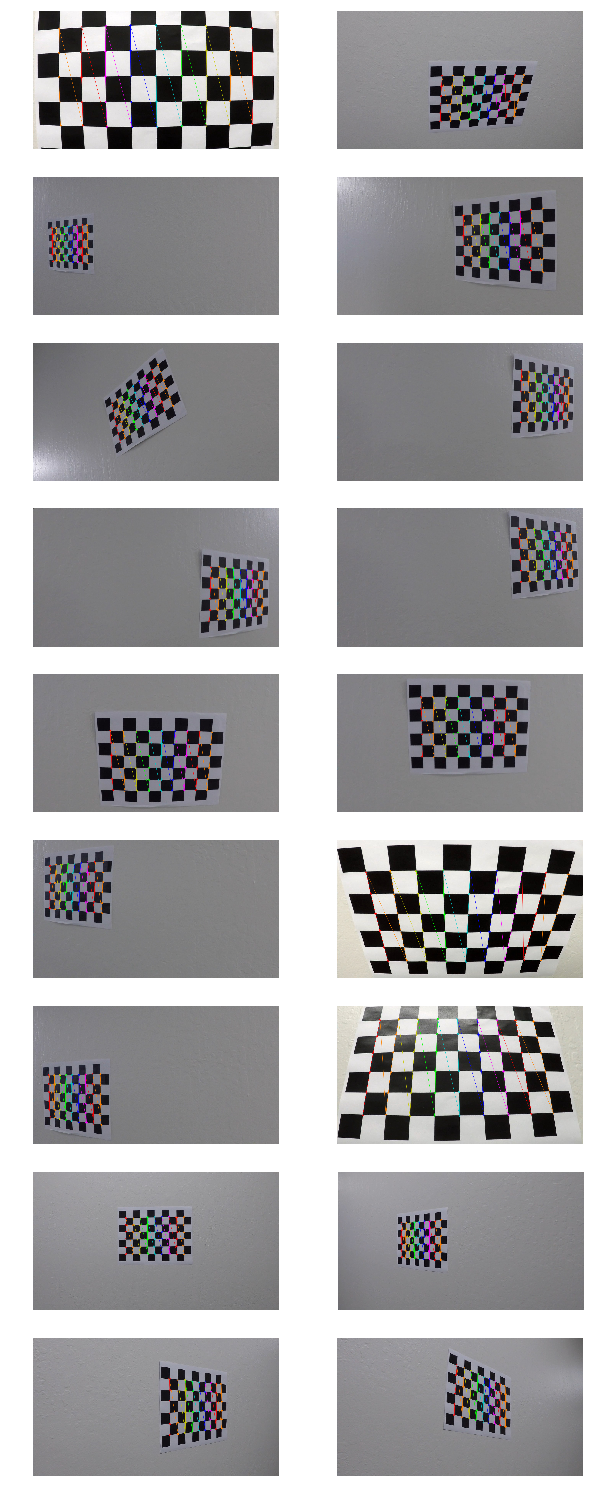

In [2]:
def calibration_matrix(path):
    # Returns camera calibration matrix using chessboard images 
    # in given glob path assuming 6x9 or 5x9 chess corners
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    images = glob.glob(path)
    total_image_count = len(images)

    image_count = 1
    fig = plt.figure()
    for filename in images:
        img = cv2.imread(filename)
        nx, ny = 6, 9
        ret, corners = cv2.findChessboardCorners(img, (nx, ny))
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0: nx, 0: ny].T.reshape(-1, 2)

        if not ret:
            nx, ny = 5, 9 # Try with 5 rows
            objp = np.zeros((nx * ny, 3), np.float32)
            objp[:, :2] = np.mgrid[0: nx, 0: ny].T.reshape(-1, 2)
            ret, corners = cv2.findChessboardCorners(img, (nx, ny))

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

            ax = fig.add_subplot(math.ceil(total_image_count / 2), 2, image_count)
            chessboard_with_corners = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            chessboard_with_corners = cv2.cvtColor(chessboard_with_corners, cv2.COLOR_BGR2RGB)
            ax.imshow(chessboard_with_corners)
            ax.axis('off')
            image_count += 1

    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None), fig

(ret, mtx, dist, rvecs, tvecs), fig = calibration_matrix(os.path.join('camera_cal','*.jpg'))
fig.set_size_inches(10, 30)

## Use 'undistort'
Use cv2.undistort and the camera calibration matrix generated from the previous block to remove distortion in a sample chessboard image and test image.

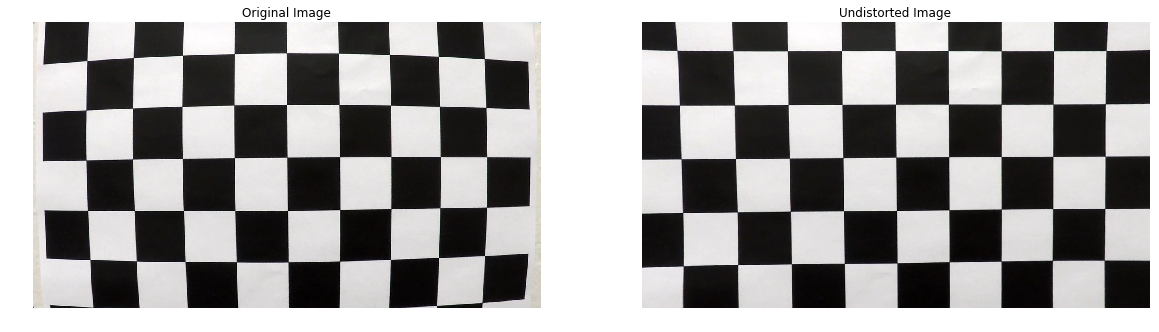

In [3]:
test_img = plt.imread(os.path.join('camera_cal', 'calibration1.jpg'))
undistorted_img = cv2.undistort(test_img, mtx, dist, None, mtx)

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.axis('off')
plt.show()

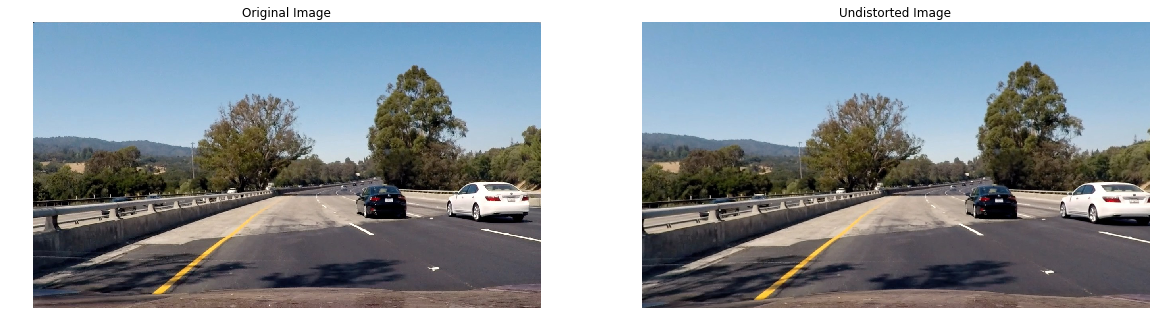

In [20]:
test_img = plt.imread(os.path.join('test_images', 'test4.jpg'))
undistorted_img = cv2.undistort(test_img, mtx, dist, None, mtx)

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.axis('off')
plt.show()

## Color and Binary Thresholding

#### Sobel gradient thresholding in X and Y direction
I used Sobel gradient thresholding to detect changes in both horizontal and vertical directions

#### HLS - Saturation channel thresholding
After the converting the RGB image to the HLS color space, I threshold the image on the saturation channel using the magnitude gradient to detect white and yellow pixels.

#### Create white and yellow masks
In the image below, the green pixels are thresholded by the yellow mask and the red pixels are thresholded by the white mask.

In [5]:
def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply Sobel Operator in X and Y directions and calculate the X and Y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray[:,:,2], cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Threshold image on saturation channel using the magnitude gradient
def threshold(img, color=False, mag_dir_thresh=False):
    img = np.copy(img)
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # White Color
    low_white = np.array([0,210,0], dtype=np.uint8)
    high_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, low_white, high_white)
    
    # Yellow Color
    low_yellow = np.array([18,0,100], dtype=np.uint8)
    high_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, low_yellow, high_yellow)  
    
    combined_binary = np.zeros_like(white_mask)
    
    # Dir Mag Threshold
    if mag_dir_thresh:
        dir_mask = dir_threshold(img)
        mag_mask = mag_thresh(img)
        combined_binary[((dir_mask == 1) & (mag_mask == 1))] = 255
        
    if color:
        return np.dstack((white_mask, yellow_mask, combined_binary))
    
    else:
        combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 255
        combined_binary[(combined_binary == 255)] = 1
        return combined_binary

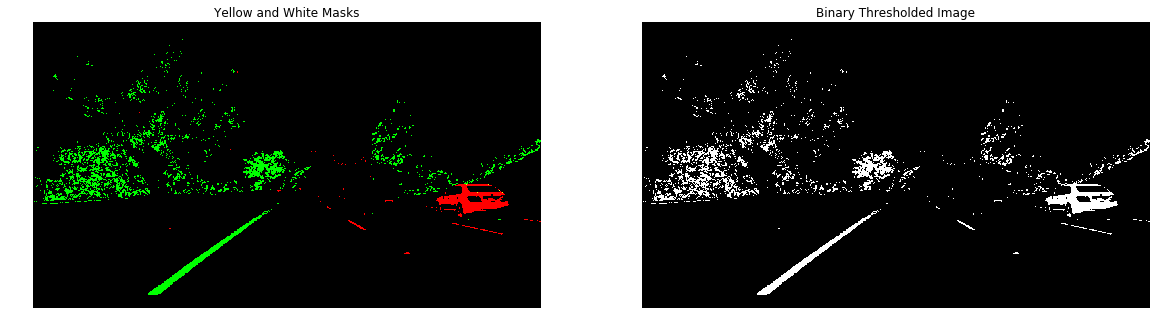

In [18]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
thresholded = threshold(test_img, color=True)
plt.imshow(thresholded)
plt.title('Yellow and White Masks')
plt.axis('off')

plt.subplot(1,2,2)
b_thresholded = threshold(test_img)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Binary Thresholded Image')
plt.axis('off')
plt.show()

In [9]:
# Save all binary images
output_dir = 'output_images/binary_test_images/'
input_dir = 'test_images/'

for file in os.listdir(input_dir):
    test_img = mpimg.imread(input_dir + file)
    binary_img = threshold(test_img)
    cv2.imwrite(output_dir + file, binary_img)
print('{} images saved to {}'.format(len(os.listdir(input_dir)), output_dir))

8 images saved to output_images/binary_test_images/


## Perspective Transform
Distortion can change the apparent size of an object in an image.
Distortion can change the apparent shape of an object in an image.
Distortion can cause an object's appearance to change depending on where it is in the field of view.
Distortion can make objects appear closer or farther away than they actually are.

A perspective transform corrects for image distortion by mapping the points in a given image to a new set of image points with a new perspective. I use the perspective transform to warp the image as if seeing the lane from above (bird's eye view). The perspective transform allows me to detect lane lines and compute the left and right lane curvatures.

The cv2.getPerspectiveTransform function requires 4 source and destination points. Since the lanes are approximated as trapezoids, I can use the 4 corners of a lane as the source points for a perspective transform. For this sample image, I have selected the following source and destination points.

|    Source     |  Destination  |
|:-------------:|:-------------:|
| (253, 697)    | (303, 697)    |
| (585, 456)    | (303, 0)      |
| (700, 456)    | (1011, 0)     |
| (1061, 697)   | (1011, 697)   |

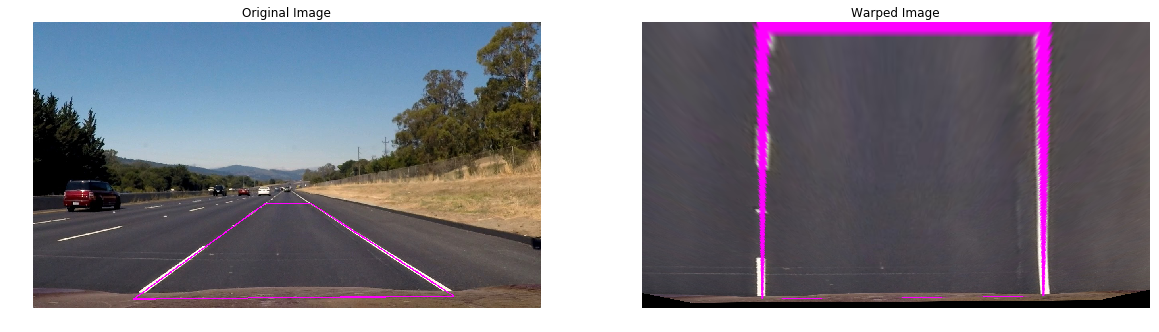

In [10]:
image = mpimg.imread('test_images/straight_lines2.jpg')
img_size = (image.shape[1], image.shape[0])

corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 697]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]

src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

warp_m = cv2.getPerspectiveTransform(src, dst)
warp_minv = cv2.getPerspectiveTransform(dst, src)

cv2.line(image, (253, 697), (585, 456), color=[255,0,255], thickness=2)
cv2.line(image, (585, 456), (700, 456), color=[255,0,255], thickness=2)
cv2.line(image, (700, 456), (1061,697), color=[255,0,255], thickness=2)
cv2.line(image, (1061,697), (253, 697), color=[255,0,255], thickness=2)

warped_img = cv2.warpPerspective(image, warp_m, img_size)

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(image)

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Warped Image')
plt.imshow(warped_img)
plt.show()

## Perspective Transform pipeline method 
I create a perspective transform method for a pipeline to detect lane lines. 

* Apply thresholding and edge detection on the image
* Mask the upper 60% of pixels to remove any image artifacts such as sky, trees, clouds
* Use Hough transforms to detect the left and right lane lines
* Find the apex where the two lines intersect. 
* Form a trapezoid: select a point based on image dimensions slightly below the apex for the upper 2 corners, continue down both left and right lane lines for the bottom 2 corners
* Pass the trapezoid points (source points) along with a hardcoded set of destination points to cv2.getPerspectiveTransform to compute the perspective transformation matrix

In the image below, I use + symbols to indicate the corners of the lane trapezoid in the original and warped images.

## Edge Detection
In addition to the Sobel first derivative operation I tried the Laplacian second derivative operation (http://docs.opencv.org/3.1.0/d5/d0f/tutorial_py_gradients.html). I used the Laplacian filter (cv2.Laplacian) and thresholded pixels to highlight only negative values (following a dark-light-dark edge fashion). The Laplacian filter generated better results than combinations of Sobel gradients.

I used these thresholding operations to create several masks to detect edges in the images. The first mask is the binary thresholded mask generated from the Laplacian filter. I apply thresholding only on the S (Saturation) channel of the image. If less than 1% of pixels were detected, then I apply the Laplacian threshold on the grayscaled image.
The second mask is a thresholding mask on the S channel pixels. The third mask is a brightness mask to reject dark lines. I combine either the second and third masks or the first and third masks.

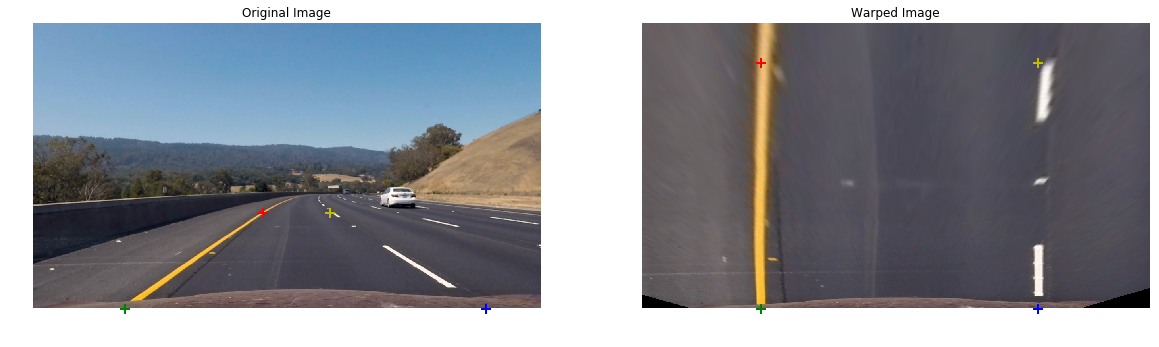

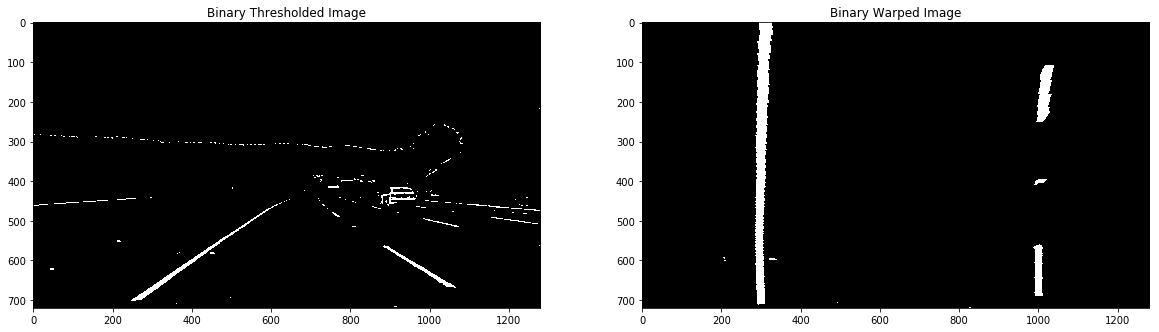

In [118]:
def detect_edges(image, ksize = 11, mask_half=False):
    # Convert image to HLS
    hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)
    gray = (0.5*image[:,:,0] + 0.4*image[:,:,1] + 0.1*image[:,:,2]).astype(np.uint8)
    s = hls[:,:,2]
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    total_px = image.shape[0]*image.shape[1]
    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
    mask3 = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
    
    if cv2.countNonZero(mask3)/total_px < 0.01:
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask3 = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

    _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    mask2 = s_binary

    combined_binary = np.clip(cv2.bitwise_and(gray_binary, cv2.bitwise_or(mask3, mask2)), 0, 1).astype('uint8')

    # Mask top half of unwarped image
    if mask_half:
        print(ceil(image.shape[0]//2))
        combined_binary[:ceil(image.shape[0]//2)] = 0

    return combined_binary

def get_perspective_transform(image, src_in=None, dst_in=None, display=False):
    img_size = image.shape
    if src_in is None:
        src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                        [705. /1280.*img_size[1], 455./720.*img_size[0]],
                        [1130./1280.*img_size[1], 720./720.*img_size[0]],
                        [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    else:
        src = src_in
        
    if dst_in is None:
        dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 720./720.*img_size[0]],
                        [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    else:
        dst = dst_in
        
    warp_m = cv2.getPerspectiveTransform(src, dst)
    warp_minv = cv2.getPerspectiveTransform(dst, src)

    if display:
        plt.subplot(1,2,1)
        plt.hold(True)
        plt.imshow(image, cmap='gray')
        colors = ['r+','y+','b+','g+']
        for i in range(4):
            plt.plot(src[i,0], src[i,1], colors[i], mew=2, ms=10)
        
        plt.axis('off')
        plt.title('Original Image')
        
        im2 = cv2.warpPerspective(image, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        plt.subplot(1,2,2)
        plt.hold(True)
        plt.imshow(im2, cmap='gray')
        for i in range(4):
            plt.plot(dst[i,0], dst[i,1], colors[i], mew=2, ms=10)
        
        plt.axis('off')
        plt.title('Warped Image')
        plt.show()
        
    return warp_m, warp_minv

image = mpimg.imread('test_images/test3.jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

yellow = (np.array([160, 128, 0]), np.array([255, 255, 128]))
hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
src = find_lanes(undistorted)
warp_m, warp_minv = get_perspective_transform(undistorted, src, display=True)

edges = detect_edges(undistorted)
lanes = cv2.warpPerspective(edges, warp_m, (undistorted.shape[1], undistorted.shape[0]), flags=cv2.INTER_LINEAR)

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.title('Binary Thresholded Image')
plt.imshow(edges, cmap='gray')


plt.subplot(1,2,2)
plt.imshow(lanes, cmap='gray')
plt.title('Binary Warped Image')
plt.show()

## Apply Binary Warping to all test images

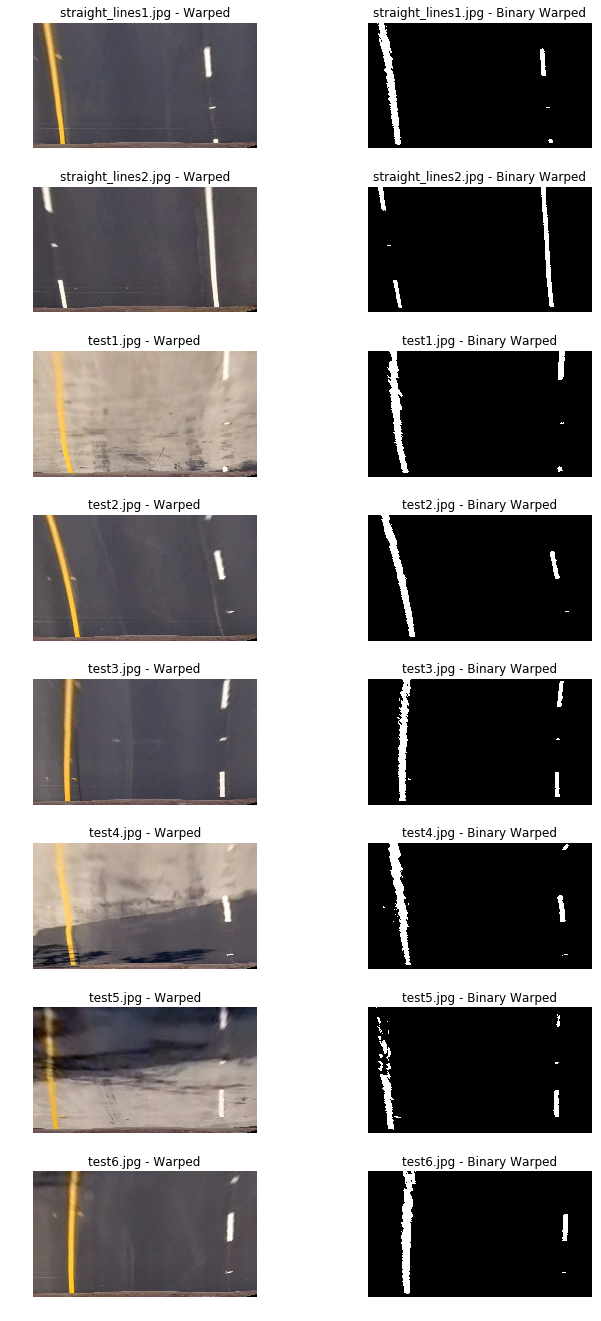

In [119]:
index = 0
plt.figure(figsize=(10, 24))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.5, hspace=0.05)

binary_images = []
for file in os.listdir('test_images/'):
    image = mpimg.imread('test_images/' + file)
    img_size = (image.shape[1], image.shape[0])
        
    ax1 = plt.subplot(gs[index])
    warp_m1 = cv2.getPerspectiveTransform(src, dst)
    undistorted = cv2.warpPerspective(image, warp_m1, img_size)
    ax1.axis('off')
    ax1.set_title('{} - Warped'.format(file))
    ax1.imshow(undistorted)
    
    index += 1
    
    binary_img = threshold(undistorted)
    binary_images.append(binary_img)
    ax2 = plt.subplot(gs[index])
    ax2.axis('off')
    ax2.set_title('{} - Binary Warped'.format(file))
    ax2.imshow(binary_img, cmap='gray')
    
    index += 1
    
plt.show()

## Lane Line Detection 
Lane line detection is completed using the sliding windows technique explained in the course. I create a histogram to add up the pixel values along each column in the binary warped image. The 2 most prominent peaks in this histogram should indicate the x-position of the lane lines starting at the bottom of the image. Using this approximation, I find all the nonzero values inside a window (1/9 of image height) with a margin of 100px, and store those points as points for the lane line. I then slide the window up, and repeat the process to find nonzero values. I use the last known line location to restrict my search for new lane pixels. When the sliding window reaches the top of the image, I fit a second order polynomial to the points that were detected. This polynomial can be used to calculate the lane line values at any point.

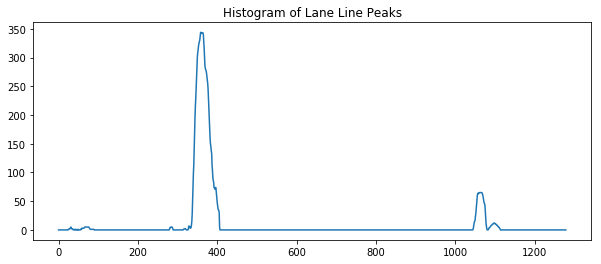

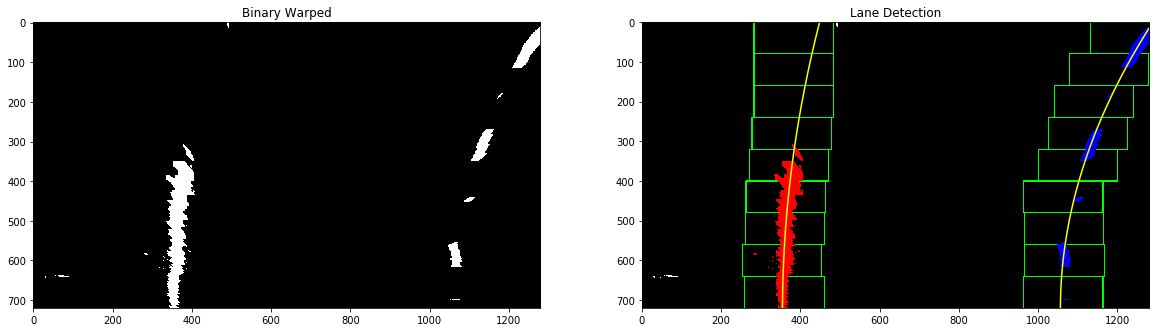

In [22]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.figure(figsize=(10, 4))
plt.plot(histogram)
plt.title('Histogram of Lane Line Peaks')
plt.show()

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detection')
plt.show()

## Lane Line Detection pipeline method 
The following methods are used to detect lane lines for an image processing pipeline. 

#### Using a histogram
I use the scipy.signal find_peaks_cwt function to identify the peaks in the histogram. I filter the identified peaks to reject any peaks close to image edges and any peaks below a specified minimum. I apply the sliding window method on the peak histogram points to extract the lane pixels. First, I split the image into 10 windows (1/10 of image height) and starting with the bottom window, search for lane lines within the windows. I use a histogram to store the x and y coordinates of all nonzero pixels. The column with the most nonzero pixels is used to estimate the lane line. Furthermore, I remove any x or y coordinates that exceed 2 standard deviations from the mean. I use the filtered pixels and a weighted average of previous lane pixels with np.polyfit to compute a second order polynomial to fit the lane line points. 

#### Using an image mask
I use the previously generated second order polynomial to create an image mask over a specific region of interest where I am most likely to find lane lines. I use this mask to remove non-lane pixels and all lane (nonzero) pixels in the region of interest to compute another second order polynomial. 

#### Highlight left and right lane lines
I use a lane line finding method similar to the one used in the first lane line finding project of this course. The left lane is highlighted in red and the right lane is highlighted in blue.

In [120]:
def find_lanes(image):
    edges = detect_edges(image, True)
    
    rho = 2               # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180   # angular resolution in radians of the Hough grid
    threshold = 100       # min votes (intersections in Hough grid)
    min_line_length = 100 # min pixels in a line
    max_line_gap = 25     # max gap in pixels between line segments

    angle_min_mag = 20*pi/180
    angle_max_mag = 65*pi/180

    lane_markers_x = [[], []]
    lane_markers_y = [[], []]
    
    masked_edges = np.copy(edges)
    masked_edges[:edges.shape[0]*6//10,:] = 0
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            theta = atan2(y1-y2, x2-x1)
            rho = ((x1+x2)*cos(theta) + (y1+y2)*sin(theta))/2
            if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag):
                if theta > 0: 
                    i = 0 # left lane marker
                else:
                    i = 1 # right lane marker
                lane_markers_x[i].append(x1)
                lane_markers_x[i].append(x2)
                lane_markers_y[i].append(y1)
                lane_markers_y[i].append(y2)

    if len(lane_markers_x[0]) < 1 or len(lane_markers_x[1]) < 1:
        return None
    
    p_left  = np.polyfit(lane_markers_y[0], lane_markers_x[0], 1)
    p_right = np.polyfit(lane_markers_y[1], lane_markers_x[1], 1)
    
    # Find intersection of the 2 lane lines
    apex_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
    top_y = ceil(apex_pt[0] + 0.075*edges.shape[0])
    
    bl_pt = ceil(np.polyval(p_left, edges.shape[0]))
    tl_pt = ceil(np.polyval(p_left, top_y))
    
    br_pt = ceil(np.polyval(p_right, edges.shape[0]))
    tr_pt = ceil(np.polyval(p_right, top_y))

    src = np.array([[tl_pt, top_y],
                    [tr_pt, top_y],
                    [br_pt, edges.shape[0]],
                    [bl_pt, edges.shape[0]]], np.float32)

    get_perspective_transform(edges, src_in=src, dst_in=None, display=False) 
    return src

from scipy.signal import find_peaks_cwt
def find_histogram_peaks(lanes, min_peak = 25.0):
    hist = np.sum(lanes[int(lanes.shape[0]*0.5):,:], axis=0)
    widths = [100]
    idx = find_peaks_cwt(hist, widths, max_distances=widths, noise_perc=50) 
    if len(idx) < 2:
        return None

    # Leave out edges
    idx = [i for i in idx if i > lanes.shape[1]*0.1 and i < lanes.shape[1]*0.9 and max(hist[i-50:i+50]) > min_peak]        
    
    return [min(idx), max(idx)], hist

## Compute Left and Right Radius of Curvature and Vehicle Position
I scale the lane pixel values to meters using the following scaling factors according to the 3.7m average lane line widths on US roads.
* Source: https://en.wikipedia.org/wiki/Lane#Lane_width
* ym_per_pix = 30/720 # meters per pixel in y dimension
* xm_per_pix = 3.7/700 # meteres per pixel in x dimension

I use these values to compute the polynomial coefficients in meters and use these coefficients to compute the left and right radius of curvature. I also compute the vehicle position assuming the camera is positioned at the center of the vehicle and and the distance between the left and right lane line midpoint and image center.

In [109]:
# Define a Lane class to describe each line detection
import collections
from itertools import chain, repeat
from functools import reduce

# Average lane line width = 3.7m
# Source: https://en.wikipedia.org/wiki/Lane#Lane_width
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

class Lane():
    def __init__(self, peak_pt, img_size, cache_length):
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=cache_length)
        self.recent_yfitted = collections.deque(maxlen=cache_length)
        
        # average x values of the fitted line over the last n iterations
        self.bestx = None   
        
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        # polynomial coefficients for the current fit
        self.current_fit = [np.array([False])]
        
        # radius of curvature of the lane line
        self.radius_of_curvature = None 
        
        # distance in meters of vehicle center from lane line
        self.vehicle_dist = 0.0 
                
        self.current_xfit = None
        self.roi_mask = None
        
        self.img_size = img_size
        self.peak_pt = peak_pt
        
        self.yvals = np.linspace(0, img_size[0], 101)
        self.mask = np.ones(img_size, dtype=np.uint8)*255
        
        self.dropped_frames = 0
    
    def add_lanes(self, x, y):
        weights = np.ones(len(self.recent_xfitted))
        if len(weights) > 1:
            weights[0] = 0.8
            weights[1:] = 0.2/(len(weights) - 1)
            w_x = reduce(lambda a,b: a+b[0]*b[1], zip(weights, self.recent_xfitted), np.zeros(len(self.yvals)))
            w_y = reduce(lambda a,b: a+b[0]*b[1], zip(weights, self.recent_yfitted), np.zeros(len(self.yvals)))
        else:
            w_x, w_y = [], []
            
        x_hist = np.fromiter(chain(w_x, x), np.int32)
        y_hist = np.fromiter(chain(w_y, y), np.int32)

        try:
            p_lane = np.polyfit(y_hist, x_hist, 2)
            rad_curvature = self.compute_rad_curvature(x_hist, y_hist)
            self.detected = self.check_ROC(rad_curvature)
        except Exception as e:
            print(e)
            self.detected = False

        if self.detected and len(p_lane) == 3:
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]
            self.current_xfit = x_fit   
            self.recent_xfitted.append(x_fit)
            self.recent_yfitted.append(self.yvals)
            self.radius_of_curvature = rad_curvature
            self.current_fit = p_lane
            self.dropped_frames = 0
        else:
            p_lane = self.current_fit
            rad_curvature = self.radius_of_curvature
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]
            self.dropped_frames += 1

        self.mask.fill(0)
        pts = np.transpose(np.vstack([x_fit, self.yvals])).reshape((-1,1,2)).astype(np.int32)
        cv2.drawContours(self.mask, pts, -1, (255,255,255), thickness=80)
        
    @staticmethod
    def compute_rad_curvature(xvals, yvals):
        fit_rc = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        y_eval = np.max(yvals)
        new_rad_curvature = ((1 + (2*fit_rc[0]*y_eval + fit_rc[1])**2)**1.5)/np.absolute(2*fit_rc[0])
        return new_rad_curvature
        
    def check_ROC(self, R):
        if self.radius_of_curvature is None:
            return True
        # check if current radius of curvature has deviated > 50%
        k = 1/R
        R0 = self.radius_of_curvature
        k0 = 1/self.radius_of_curvature
        self.vehicle_dist = abs(R-R0)/R0
        return self.vehicle_dist <= 0.5
             
    def detect_mask_lanes(self, image):
        mask_lanes = cv2.bitwise_and(image, self.mask)
        all_pts = cv2.findNonZero(mask_lanes)
        if all_pts is not None:
            all_pts = all_pts.reshape((-1,2))
            self.add_lanes(all_pts[:,0], all_pts[:,1])
        else:
            self.detected = False
           
    def draw_lane(self, image):
        pts = np.array([np.transpose(np.vstack([self.current_xfit, self.yvals]))])
        cv2.fillPoly(image, np.int_([pts]), (0,255, 0))
        return image
    
def remove_outliers(x_list, y_list):
    if not x_list or not y_list:
        return x_list, y_list
    mu_x, mu_y = np.mean(x_list), np.mean(y_list)
    sigma_x, sigma_y = np.std(x_list), np.std(y_list)
    new_x, new_y = zip(*[(x, y) for (x,y) in zip(x_list, y_list) 
                       if abs(x - mu_x) < 2*sigma_x and abs(y - mu_y) < 2*sigma_y])
    return new_x, new_y

def histogram_lane_detection(image, left_lane, right_lane, peak_pts, num_bands=10, window_width=0.2):
    height = image.shape[0]
    band_height = int(1./num_bands * height)
    band_width = int(window_width*image.shape[1])
    left_x, left_y, right_x, right_y = [], [], [], []
    peak_left, peak_right = peak_pts
    idx_left, idx_right = peak_pts
    
    for i in reversed(range(num_bands)):
        w_left = image[i*band_height:(i+1)*band_height,peak_left-band_width//2:peak_left+band_width//2]
        w_right = image[i*band_height:(i+1)*band_height,peak_right-band_width//2:peak_right+band_width//2]
        left_y_pt, left_x_pt = np.nonzero(w_left)
        right_y_pt, right_x_pt = np.nonzero(w_right)
        
        left_x.extend(left_x_pt + peak_left-band_width//2)
        left_y.extend(left_y_pt + i*band_height)
        right_x.extend(right_x_pt+ peak_right-band_width//2)
        right_y.extend(right_y_pt+ i*band_height)

        s_left = np.sum(w_left, axis=0)
        s_right = np.sum(w_right, axis=0)
        if np.any(s_left > 0):
            peak_left = np.argmax(s_left) + peak_left-band_width//2
        if np.any(s_right > 0):
            peak_right = np.argmax(s_right) + peak_right-band_width//2

    left_x, left_y = remove_outliers(left_x, left_y)
    right_x, right_y = remove_outliers(right_x, right_y)
    
    left_lane.add_lanes(left_x, left_y)
    right_lane.add_lanes(right_x, right_y)

    return left_lane, right_lane

## Image Processing Pipeline 
The steps in my pipeline are:
* Color Transforms and Gradients 
* Perspective Transform
* Edge Detection
* Binary Thresholding
* Lane Line Detection

The following are processed images put through the pipeline.

CPU times: user 936 ms, sys: 147 ms, total: 1.08 s
Wall time: 1.07 s
CPU times: user 323 ms, sys: 34 ms, total: 357 ms
Wall time: 281 ms


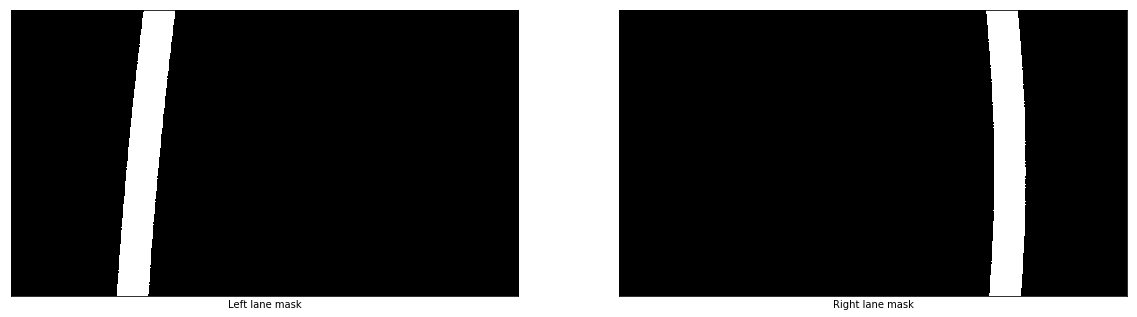

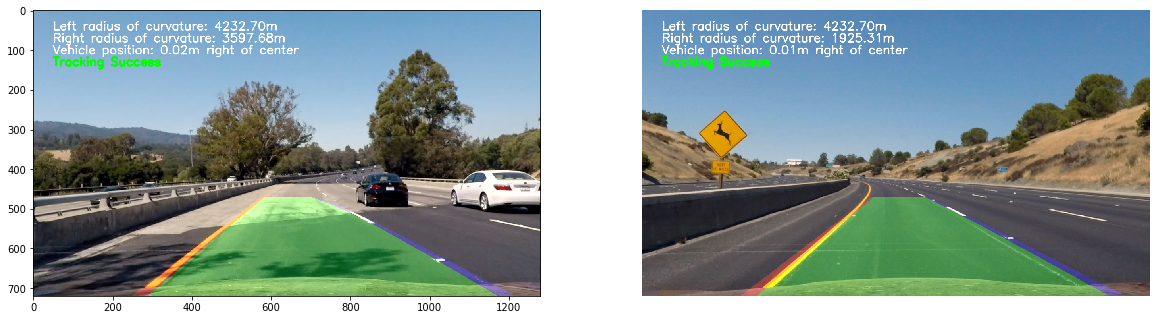

In [121]:
def pipeline(image, key_frame_interval=20, cache_length=10):
    global mtx, dist
    
    if pipeline.cache is None:        
        left_lane = Lane(int(0.15*image.shape[0]), image.shape[:2], cache_length=cache_length)
        right_lane = Lane(int(0.63*image.shape[0]), image.shape[:2], cache_length=cache_length)
        cache = {'mtx': mtx,
                 'dist': dist,
                 'warp_m': None,
                 'warp_minv': None,
                 'frame_ctr': 0,
                 'left': left_lane,
                 'right': right_lane,
                 'peak_pts': None}
    else:
        cache = pipeline.cache
    
    left_lane = cache['left']
    right_lane = cache['right']

    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    if cache['warp_m'] is None:
        src = find_lanes(undistorted)
        warp_m, warp_minv = get_perspective_transform(image, src_in = src)
        
        if src is not None:
            cache['warp_m'] = warp_m
            cache['warp_minv'] = warp_minv
    else:
        warp_m, warp_minv = cache['warp_m'], cache['warp_minv']
    
    warp_img = cv2.warpPerspective(undistorted, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    warp_edges = detect_edges(warp_img)
    
    peak_pts = cache['peak_pts']
    if peak_pts is None: 
        new_peak_pts, _ = find_histogram_peaks(warp_edges)

        if new_peak_pts is not None:
            peak_pts = new_peak_pts
        else:
            # Could not find new peak points
            cache['frame_ctr'] = cache['frame_ctr'] - 1 # Try again in the next frame
            return undistorted

    if ((left_lane.current_xfit is None or left_lane.dropped_frames > 16) 
            or (right_lane.current_xfit is None or right_lane.dropped_frames > 16)):
        left_lane.radius_of_curvature = None
        right_lane.radius_of_curvature = None
        histogram_lane_detection(warp_edges, left_lane, right_lane, peak_pts)
    else:
        left_lane.detect_mask_lanes(warp_edges)
        right_lane.detect_mask_lanes(warp_edges)

    cache['frame_ctr'] = cache['frame_ctr'] + 1
    cache['peak_pts'] = peak_pts
    pipeline.cache = cache
    
    yvals = left_lane.yvals
    left_fitx = left_lane.current_xfit
    right_fitx = right_lane.current_xfit
    
    # Create a blank image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))    

    # Draw lane markers
    pts = np.transpose(np.vstack([left_lane.current_xfit, left_lane.yvals])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (255,0,0), thickness=30)
    pts = np.transpose(np.vstack([right_lane.current_xfit, right_lane.yvals])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (0,0,255), thickness=30)

    # Warp the blank image back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, warp_minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    left_r = left_lane.radius_of_curvature
    right_r = right_lane.radius_of_curvature
    middle = (left_fitx[-1] + right_fitx[-1])//2
    vehicle_position = image.shape[1]//2
    
    dx = (vehicle_position - middle)*xm_per_pix

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left radius of curvature: %.2fm'%(left_r), (50,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature: %.2fm'%(right_r), (50,80), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result,'Vehicle position: %.2fm %s of center'%(abs(dx), 'left' if dx < 0 else 'right'), (50,110), 
                font, 1, (255,255,255), 2, cv2.LINE_AA)

    is_tracking = left_lane.detected or right_lane.detected
    cv2.putText(result,'Tracking Success' if is_tracking else 'Tracking Error',(50,140),
        font, 1, (0,255,0) if is_tracking else (255,0,0), 3, cv2.LINE_AA)

    plt.subplot(1,2,1)
    plt.imshow(left_lane.mask, cmap='gray')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel('Left lane mask')

    plt.subplot(1,2,2)
    plt.imshow(right_lane.mask, cmap='gray')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel('Right lane mask')
    
    cache['left'] = left_lane
    cache['right'] = right_lane

    return result

def clear_cache():
    pipeline.cache = None
    
pipeline.clear_cache = clear_cache
clear_cache()
image1 = mpimg.imread('test_images/test4.jpg')
image2 = mpimg.imread('test_images/test2.jpg')
%time pipeline(image1)
%time pipeline(image2)
out1 = pipeline(image1)
out2 = pipeline(image2)
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(out1)
plt.subplot(1,2,2)
plt.imshow(out2)
plt.axis('off')
plt.show()

## Results and Discussion 

This pipeline was overall quite successful in identifying lane lines in the project videos. The pipeline has some difficulty keeping track of the lanes in both challenge videos. The resulting output videos are available in the same directory.

The harder challenge video provides no separating median strip blocking the view of opposing traffic, is filmed under different lighting conditions (or different time of day), contains sharper turns, contains a smaller lane, and contains closer distracting artifacts that take up more space in the image and obscure the lane (trees, tree shadows, foliage, grass, etc). My pipeline had difficulty with the illumination and color shade variation in the challenge videos.

This project highlighted the significance of the Convolutional Neural Network and Deep Learning based approach used in the previous project for behavioral cloning.

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [07:15<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 54s, sys: 39.9 s, total: 7min 34s
Wall time: 7min 16s


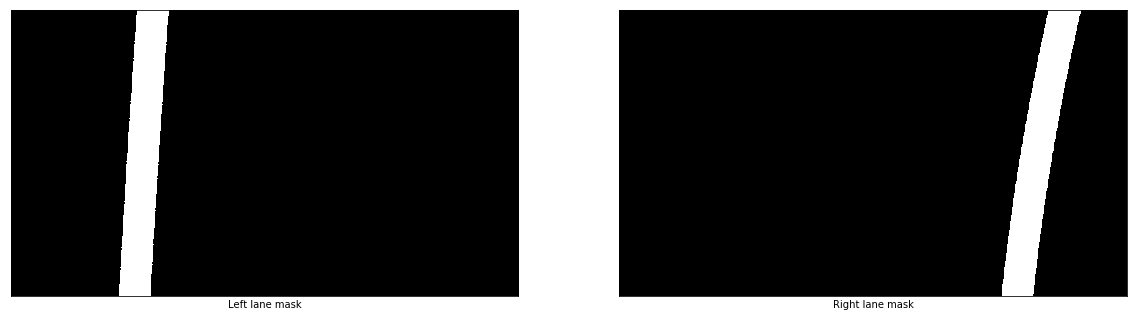

In [122]:
clear_cache()
output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
video_clip = clip.fl_image(pipeline)
%time video_clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:33<00:00,  3.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 36s, sys: 14.2 s, total: 2min 50s
Wall time: 2min 34s


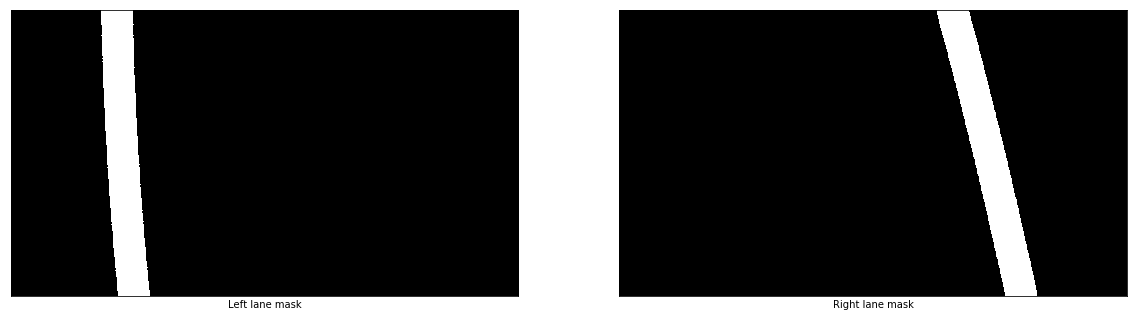

In [123]:
clear_cache()
output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
video_clip = clip2.fl_image(pipeline)
%time video_clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [06:15<00:00,  3.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 5min 55s, sys: 38.6 s, total: 6min 34s
Wall time: 6min 17s


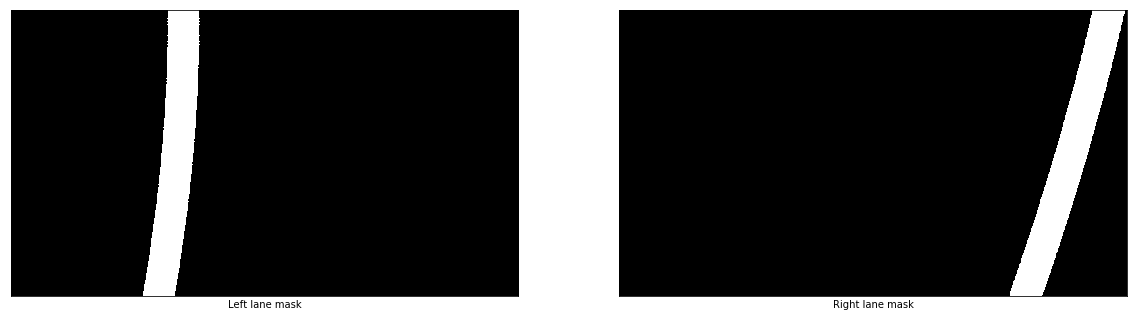

In [124]:
clear_cache()
output = 'harder_challenge_video_output.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
video_clip = clip2.fl_image(pipeline)
%time video_clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))